# Mobility data analysis

*Author: Liubov*; *Collaborators: Marc, Bastian*

Notebook inspired from Open humans project https://www.openhumans.org

Read mobility files from Open humans
https://www.openhumans.org/api/public-data/?source=direct-sharing-138


Thanks to Bastian for inspiration from their notebooks 
https://exploratory.openhumans.org/notebooks/?source=Moves%20connection


In [1]:

import json
from pprint import pprint


'''
Functions:
 to estimate the distribution of stop duration
 to estimate the distribution of jump length
'''

def duration_stop_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns sorted distribution of stops duration
        Can be misleading for days w/ lots of travel etc. 
    """
    places_of_day = []
    duration_seq = [] #sequence of durations of stops
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            duration_seq.append([duration])
    duration_seq.sort() 
    return duration_seq 

def len_jumps_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns the distribution of jumps lengths (calculated from lat/long of stops)
    can be misleading for days w/ lots of travel etc. 
    """
    places_of_traj = [] #returns array of all locations during the day
    for i in daily_segments: 
        if i['type'] == 'place':
            place_location = i['place']['location']
            places_of_traj.append([place_location])
    return places_of_traj


def longest_daily_location(daily_segments):
    """
    Function from Bastian (Open Humans)
    
    Bastian did analysis of most popular location data in his notebook for Open humans
    https://exploratory.openhumans.org/notebooks/?source=Moves%20connection
    
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]







### Data example
Example of data 
Read mobility files from Open humans (json format)

https://www.openhumans.org/api/public-data/?source=direct-sharing-138
  

[{'caloriesIdle': 1679,
  'date': '20130515',
  'lastUpdate': '20151001T012320Z',
  'segments': [{'activities': [{'activity': 'walking',
                                'calories': 3,
                                'distance': 48.0,
                                'duration': 50.0,
                                'endTime': '20130515T131851-0700',
                                'group': 'walking',
                                'manual': False,
                                'startTime': '20130515T131801-0700',
                                'steps': 96,
                                'trackPoints': []}],
                'endTime': '20130515T132742-0700',
                'lastUpdate': '20151001T012320Z',
                'place': {'id': 61807543,
                          'location': {'lat': 33.99882, 'lon': -118.43657},
                          'name': 'Ramuilar HQ',
                          'type': 'home'},
                'startTime': '20130515T131401-0700',
                'type': 'place'},
               {'activities': [{'activity': 'transport',
                                'distance': 3503.0,
                                'duration': 534.0,
                                'endTime': '20130515T133636-0700',
                                'group': 'transport',
                                'manual': False,
                                'startTime': '20130515T132742-0700',
                                'trackPoints': []}],
                'endTime': '20130515T133637-0700',
                'lastUpdate': '20130515T213146Z',
                'startTime': '20130515T132742-0700',
                'type': 'move'},
               {'activities': [{'activity': 'walking',
                                'calories': 5,
                                'distance': 92.0,
                                'duration': 90.0,
                                'endTime': '20130515T134039-0700',
                                'group': 'walking',
                                'manual': False,
                                'startTime': '20130515T133909-0700',
                                'steps': 184,
                                'trackPoints': []}],
                'endTime': '20130515T142848-0700',
                'lastUpdate': '20140301T070136Z',
                'place': {'foursquareCategoryIds': ['4bf58dd8d48988d14e941735'],
                          'foursquareId': '4a6bdc59f964a52020d01fe3',
                          'id': 61855165,
                          'location': {'lat': 33.99050413968406,
                                       'lon': -118.4649780392647},
                          'name': 'Gjelina',
                          'type': 'foursquare'},

## Main questions about the mobility dataset
Each trajectory seems random and it is hard to compare one trajectory $Tr_1(t)$ to another $Tr_2(t)$. 
Primarily we are interested in properties of spatial and temporal properties of $Tr_i(t)$: 
1. distribution of duration of stops of human trajectories p(t)
2. distribution of length of jumps between two stops q(r)

These properties (distributions p(t) and q(r)) can help us to see, how different are patterns of their trajectories $Tr_i(t)$ for different people from distributions of duration of stops and lengths of jumps.

## Data preprocessing


In [2]:
# main function analyzing moves_data    
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

with open('moves-storyline-data.json') as f:
    moves_data = json.load(f)
    
with open('moves-storyline-data98933.json') as f: #uploading different datafiles
    moves_data2 = json.load(f)

with open('moves-storyline-data98972.json') as f:
    moves_data3 = json.load(f)   
    
#for printing this huge file of trajectories:    
#pprint(data)
    

moves_processed_data = defaultdict(list) #empty dict for processed dataframe

'''
function to create new dataframe from the json trajectory file
code adapted from openhumans notebook
'''

def dataframe_from_json(moves_data):
    for datapoint in moves_data:
        # we need to have observed segments for that day. If moves wasn't running we ignore the day
        if datapoint['segments'] != None:
            # did we stay in a place that day and did we walk that day?
            has_places = False
            walked = False
            for i in datapoint['segments']:
                if i['type'] == 'place':
                        # yes, we were in one place w/o moving around too much, we can keep this day
                        has_places = True
                        
            # is this day in our date range of interest and has data?
            if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
                moves_processed_data['date'].append(datapoint['date'])
                for activity in datapoint['summary']:
                    if activity['activity'] == 'walking':
                        moves_processed_data['steps'].append(activity['steps'])
                        moves_processed_data['distance'].append(activity['distance'])
                        walked = True
                        
                # in case of not walking, step count is zero
                if not walked:
                    moves_processed_data['steps'].append(0)
                    moves_processed_data['distance'].append(0)  
                    
                # distribution of stops lengths
                stops_distrib = duration_stop_distribution(datapoint['segments'])
                moves_processed_data['duration'].append(stops_distrib)
                location = longest_daily_location(datapoint['segments'])
                moves_processed_data['lat'].append(location['lat'])
                moves_processed_data['lon'].append(location['lon'])    
    
    
    
    #Now that we have all of the data we can convert it into a single pandas dataframe for easier processing and visualization
    
    moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    })   
    
    return moves_dataframe

# function to get data from json data
df1 = dataframe_from_json(moves_data)
df2 = dataframe_from_json(moves_data2)
df3 = dataframe_from_json(moves_data3)

#print shape of data
array_distance = df1.distance.values 
type(array_distance)


print('Now data looks like...')
df1.head(10)

Now data looks like...


,date,steps,distance,latitude,longitude
0,20160602,8732,6994.0,32.716960,-117.13974
1,20160603,5773,4391.0,33.998820,-118.43657
2,20160604,3083,2232.0,33.998820,-118.43657
3,20160605,6676,4216.0,33.998820,-118.43657
4,20160606,4936,3136.0,33.998820,-118.43657
5,20160607,7130,5342.0,33.998820,-118.43657
6,20160608,4880,3641.0,33.998820,-118.43657
7,20160609,3892,2730.0,33.998820,-118.43657
8,20160611,5363,3946.0,32.804227,-117.25982
9,20160612,3458,2406.0,32.804227,-117.25982


## Make analysis of trajectories
We start with analysis of distributions of coordinates

Distribution for lon, lat


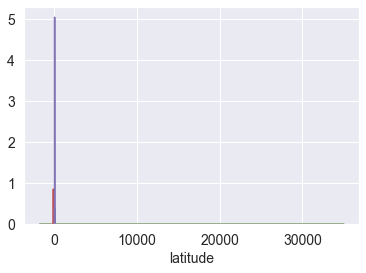

In [3]:
# plot the distribution of latitude and longitude together to make a comparison
'''
TODO:
to plot latitude and longitude  (on different axes)
geolocation as a map

'''
#Now we plot distribution of moves from new dataframe 
# We compare moves from 1st trajectory and 2nd trajectory

sns.distplot(df1['distance'])
sns.distplot(df2['distance'])
sns.distplot(df3['distance'])
# sns.distplot(stops_distrib)


print('Distribution for lon, lat')
sns.distplot(df3['longitude'])
sns.distplot(df3['latitude'])

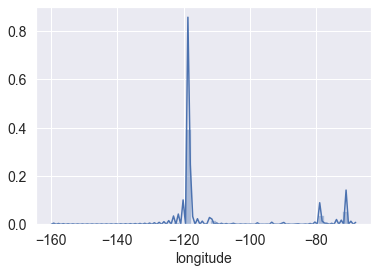

In [4]:
sns.distplot(df3['longitude'])

## Study distrubutions of jumps

In [ ]:
# we estimate distances between lat, lon of cooridinates

import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns



import osmnx as ox
from math import sin, cos, sqrt, atan2, radians



# approximate radius of earth in km
R = 6373.0
def dist_km(lat1,lat2,lon1,lon2):
    #function to calculate the distance between two locations
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance 


size = int(df1.shape[0])
print('size ', size )
#print(df1.columns)


dist_array = np.zeros(size)
for ind in range(0, size-1):
    lat1 = df1.latitude.iloc[ind] #df1['latitude'].iloc[ind]
    lat2 = df1.latitude.iloc[ind+1]
    lon1 = df1.longitude.iloc[ind]
    lon2 = df1.longitude.iloc[ind+1]
    dist_array[ind] = dist_km(lat1,lat2,lon1,lon2)

fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(dist_array, bins=20)
plt.xlabel("distance")
plt.ylabel("distribution") #frequency
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.sort(dist_array))
xaxis =  np.linspace(start = 0, stop = size, num = size)
plt.fill_between(xaxis, np.sort(dist_array), color='#539ecd') #color area under curve
plt.xlabel("jump number")
plt.ylabel("distance")
plt.show()


### Observations from data analysis

By looking at the variation of latitude and longitude coordinates we can see bimodality of trajectories, 
which correspond, most probably to "home" <-> "work". 
We will explore this below using CTRW models.



In [4]:
'''
We plot location of the most popular places from trajectories.
Input:
latitude and longitude from dataframe moves_dataframe
  moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    }) 

Output:
Folium map with datapoints
'''

import folium


#first we get trajectory datapoints from the file
latitude1 = df1.latitude.values
longitude1 = df1.longitude.values
latitude2 = df2.latitude.values
longitude2 = df2.longitude.values
latitude3 = df3.latitude.values
longitude3 = df3.longitude.values

#then we zip two arrays of lat, lon of datapoints
latlon1 = list(zip(latitude1, longitude1))
latlon2 = list(zip(latitude2, longitude2))
latlon3 = list(zip(latitude3, longitude3))
#print(latlon)

#We put map to show first location of New York 40.7808 et la longitude de la ville de New York City est -73.9772.

mapit = folium.Map( location=[40.7808 , -73.9772], zoom_start=6 )
for coord in latlon3:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )
mapit


#draw connecting line between locations written in latlon file

'''
TODO:
to add information to nodes of the map with added info about cities; 
plot curved ages multigraph
'''

SAF=folium.PolyLine(locations=latlon1,weight=5,color = 'red')
mapit.add_child(SAF)

#  Continuous time random walk analysis of trajectories
### Definition
*Continuous time random walk* (CTRW) is a generalization of a random walk where the wandering particle waits for a random time between jumps. 
It is a stochastic jump process with arbitrary distributions of jump lengths and waiting times.
More generally it can be seen to be a special case of a Markov renewal process. 

Important properties of CTRW are r(t) and d(t) distributions of lengths of jumps and durations correspondingly. 

For more details look at code and papers here 
https://github.com/Liyubov/networks_random_walking

### Analysis 

We use here several methods of analysis of trajectories using CTRW framework. 

1. Standard deviation. 
Given the input trajectory r(t) =(x(t),y(t)), we first estimate standard deviation for trajectory (STD), which is just the root of variance so var(τ)=(Var(r(t)-r(t-τ))), calculating it in Euclidean space.


2. 
One can also estimate Hurst exponent, which is used as a measure of long-term memory of time series
https://en.wikipedia.org/wiki/Hurst_exponent#Estimating_the_exponent.
Hurst exponent relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases. 
For any trajectory we can write $Var(τ) ∝ τ^{(2H)}$, where $H$ is the Hurst exponent.
Hence $(Var(z(t)-z(t-τ))) ∝ τ^{(2H)}$. 
Then 
$[log (Var(z(t)-z(t-τ))) / log τ ] / 2 ∝ H$ (gives the Hurst exponent) where we know the term in square brackets on far left is the slope of a log-log plot of tau and a corresponding set of variances.
*Range of Hurst exponent.*
A value H in the range 0.5–1 indicates a time series with long-term positive autocorrelation, meaning both that a high value in the series will probably be followed by another high value and that the values a long time into the future will also tend to be high. A value in the range 0 – 0.5 indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high, with this tendency to switch between high and low values lasting a long time into the future. A value of $H=0.5$ can indicate a completely uncorrelated series.

Basically, the idea of Hurst exponent is to characterize trajectory in terms of self-repetition. If Hurst exponent is between $[0,0.5]$, then it indicates that trajectory has switches between different regimes. 
While if Hurst exponent  $[0.5, 1]$, then it means that there are less switches between long and short jumps and trajectory has long-term positive autocorrelation. If Hurst exponent is 0.5, then it indicates completely uncorrelated series (although it depends on scales). 




In [5]:

'''
We adapt the function to estimate:
1.  STD of trajectories;
2.  Hurst exponent for trajectories.

'''


print("Calculating STD of the first trajectory ")  

#load trajectory in 2D 
data1 = np.asarray(latlon1)
print("std of trajectory : ", np.std(data1)) 


lags = range(2,100)
def hurst_exponen_chan(p):
    '''
    given time-series p(t), where t is time 
    '''    
    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

print('hurtst exponent')
print(hurst_exponen_chan(data1))


Calculating STD of first trajectory 
std of trajectory :  75.8244193362
hurtst exponent
0.0316731771675


### Estimation of scaling exponent of trajectory 

Given trajectory displacements r(t) = t^(-b-1),  we estimate b constant from the trajectory. 
Then  we fit this distribution of travelling distances to a power law. 

If parameter b<2, then this indicates that trajectories are reminiscent of scale-free random walks known as Le´vy flights. If parameter b>2, this indicates that trajectory generating process is related to normal spreading.

For this we are using Python package for  analysis of diffusion data
https://diffusion-analysis-md-simulations.readthedocs.io/en/latest/diffusion_analysis.html

    *diffusion_analysis.fit_anomalous_diffusion_data(time_data_array, MSD_data_array, degrees_of_freedom=2)*
    
function should fit anomalous diffusion data to Equation 1 in [Kneller2011], and return appropriate diffusion parameters:    MSD=ND_αt^α.


In [19]:
'''
We adapt the function to estimate:
1.  STD of trajectories;
2.  beta scaling exponent 
'''

import numpy as np 
#to prepare for diffusion analysis, load my github-hosted diffusion module:
import sys; sys.path.append('/sansom/sc2/bioc1009/github_projects/diffusion_utility/diffusion_analysis_MD_simulations')
#import diffusion_analysis


print("Calculating beta scaling exponent of first trajectory ")  

#load trajectory in 2D 
data1 = np.asarray(latlon1)
print("std of trajectory : ", np.std(data1)) 

#diffusion_analysis.fit_anomalous_diffusion_data(time_data_array, MSD_data_array)


Calculating beta constant of first trajectory 
std of trajectory :  75.8244193362


## Convex hull analysis of trajectories 

Given trajectory in 2D (in general in N dimensions) we can characterize some of its properties by the applying convex hull algorithms. 

### Example

Given random trajectory in N-dimensions 
<img src="convex.png" alt="Drawing" style="width: 200px;"/>
we draw the polygon around it, and estimate its volume, which allows us to characterize the trajectory qualitatively .


General information about convex hull
https://en.wikipedia.org/wiki/Convex_hull

data [[  32.71696    -117.13974   ]
 [  33.99882    -118.43657   ]
 [  33.99882    -118.43657   ]
 ..., 
 [  33.92070436 -118.39771521]
 [  33.95853238 -118.43698164]
 [  33.95853238 -118.43698164]]


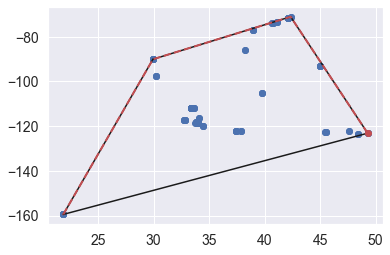

Volume is 1.33
Area is 10.47


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
#from RDP import rdp #import rdp
import networkx as nx
from scipy.spatial import ConvexHull


N = 10 # number of points  
M = 5 # dimensions

"""
LOADING input data:
# entries:  public_i pub_tag_i pub_time_i  
# public#i (Name and title encoded into number -> separate table) 
# tag of publication: there are finite number of tags (some of them are not corresponding to one field)
# time index is better to make in linear scale -> 1:365*y, where y is number of years)
"""

#data points should be data from trajectories of researchers
data = np.random.rand(N,M) #generate N datapoints in M dimensions
#data = np.random.rand(30, 2)   # 30 random points in 2-D

#load trajectory from Openhumans file
data1 = np.asarray(latlon1) #give array, not the list
data2 = np.asarray(latlon2) #get data from the second participant

#print(data)
                       
"""
function ALGORITHM convext hull
"""
         

def convex_hull(data):
              
    hull = ConvexHull(data)
    print('data', data)

    plt.plot(data[:,0], data[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(data[simplex, 0], data[simplex, 1], 'k-')
    
    
    plt.plot(data[hull.vertices,0], data[hull.vertices,1], 'r--', lw=2)
    plt.plot(data[hull.vertices[0],0], data[hull.vertices[0],1], 'ro')
    plt.show()   


    """
    estimate the volume of the convex hull for trajectory in time frame
    """ 


    points = np.array([[-1,-1, 1], [1, 1, 0], [-1, 1, 0], [1,-1, -1]])
    hull = ConvexHull(points)
    print("Volume is %2.2f" % hull.volume) # N-d object
    print("Area is %2.2f" % hull.area) # (N-1)-d object

    
'''
Now we apply convex hull to different data
'''
convex_hull(data1)
#convex_hull(data2)
    

### Convex hull sliding window analysis of trajectories
We also analyze trajectory using sliding window analysis, where we measure the volume of convex hull V(t,t+delta t) for trajectory X(t) during the period of (delat t). 
To read more about convex hull algorithm applied to particle trajectories 
https://arxiv.org/pdf/1708.06517.pdf

steps  1424
making sliding window analysis...


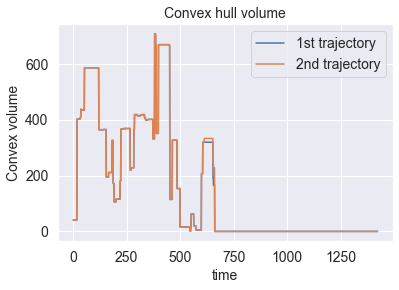

In [13]:


import matplotlib.pyplot as plt
import numpy as np
import os
#from RDP import rdp #import rdp
import networkx as nx
from scipy.spatial import ConvexHull


N = 10 # number of points  
M = 5 # dimensions

"""
LOADING input data:
# entries:  public_i pub_tag_i pub_time_i  
# public#i (Name and title encoded into number -> separate table) 
# tag of publication: there are finite number of tags (some of them are not corresponding to one field)
# time index is better to make in linear scale -> 1:365*y, where y is number of years)
"""

#data points should be data from trajectories of researchers
#data = np.random.rand(N,M) #generate N datapoints in M dimensions
#data = np.random.rand(30, 2)   # 30 random points in 2-D

#load trajectory from Openhumans file
data1 = np.asarray(latlon1) #give array, not the list
#data2 = np.asarray(latlon2) #get data from the second participant

#print(data)
                       
"""
function ALGORITHM convext hull
"""
size_window = 100 #sliding window should not be too small, otherwise it is not convex
size_window2 = 200 #we study how changing the sliding window changes the convex hull

steps = np.size(data1) 
print('steps ', steps)

                       
def convex_hull_window(data):
              
    hull = ConvexHull(data)

#    plt.plot(data[:,0], data[:,1], 'o')
#    for simplex in hull.simplices:
#        plt.plot(data[simplex, 0], data[simplex, 1], 'k-')   
#    plt.plot(data[hull.vertices,0], data[hull.vertices,1], 'r--', lw=2)
#    plt.plot(data[hull.vertices[0],0], data[hull.vertices[0],1], 'ro')
#    plt.show()   


    #points = np.array([[-1,-1, 1], [1, 1, 0], [-1, 1, 0], [1,-1, -1]])
    #hull = ConvexHull(data)
    #print(hull.volume) # Volume of N-d object "Volume is %2.2f" % 
    #print("Area is %2.2f" % hull.area) # (N-1)-d object
    return hull.volume


def convex_hull_sliding_window(data, steps, size_window):
    '''
    data - trajectory
    steps - number of time steps in trajectory 
    size_window - time size of the sliding window
    '''

    volume_array = np.zeros(steps)
    
    for itime in range(0, int((steps-size_window)/2)): #steps-1):
        #print(itime)
        time_max = (itime +size_window)%(steps+1) #calculate maximum time for sliding window
        data_i = data[itime: time_max] #cut data_i  from origianal data by cutting trajectory 
        volume_array[itime] = convex_hull_window(data_i)#apply convex_hull function
        #make exception for non-convex areas
    return volume_array

'''
Apply sliding window analysis to example trajectory
'''


print('making sliding window analysis...')

conv_array1 = convex_hull_sliding_window(np.asarray(data1), steps, size_window)

conv_array1 = convex_hull_sliding_window(np.asarray(data1), steps, size_window2)
                                         
conv_array2 = convex_hull_sliding_window(np.asarray(data2), steps, size_window)


#np.savetxt('convex_array.out', conv_array)#, delimiter=',') 
plt.plot(conv_array1)
plt.plot(conv_array2)
plt.title("Convex hull volume")
plt.xlabel("time") 

# TODO: 
# 1. to plot xaxis for days on x-axis
# 2. extract from data seasonality 
# 3. make statistics about visits of cities; bimodality: where people are traveling and where people stay 
# 4. can we identify places for conferences from this data? 
# 5. extract max radius for which people can travel 

plt.ylabel("Convex volume")
plt.legend(['1st trajectory', '2nd trajectory']) #plt.legend(["Time window size"])
plt.show()


### Recurrence network analysis of trajectories

(under construction). 
Given the trajectory (in 2D or 3D) we can calculate its recurrence matrix.

<img src="recurrence.JPG" alt="Drawing" style="width: 200px;"/>



In [ ]:
# code adapted from recurrence netwokr analysis

#!/usr/bin/python
# coding: UTF-8
from __future__ import division, print_function
import numpy as np
import pylab as plt
from scipy.spatial.distance import pdist, squareform

def rec_plot(s, eps=0.10, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d) #distance
    return Z

def moving_average(s, r=5):
    return np.convolve(s, np.ones((r,))/r, mode='valid')

if __name__ == "__main__":
    # Generate singal
    N = 200
    eps = 0.1
    steps = 10

    ru = np.random.uniform(low=-1, high=1, size=N)
    ru_filtered = moving_average(ru)

    # Plot unifrom dist filtered with moving average

    plt.title("Normal")
    plt.subplot(221)
    plt.plot(ru_filtered)
    plt.title("Unitary")
    plt.subplot(223)
    plt.imshow(rec_plot(ru_filtered, eps=eps, steps=steps))

    # Plot normal dist filtered with moving average
    rn = np.random.normal(size=N)
    rn_filtered = moving_average(rn)

    plt.subplot(222)
    plt.plot(rn_filtered)
    plt.title("Normal")
    plt.subplot(224)
    plt.imshow(rec_plot(rn_filtered, eps=eps, steps=steps))

    plt.show()


### Scaling laws
Now we analyze scaling laws of human travels, inspired by work [The scaling laws of human travel] by D. Brockmann1,2, L. Hufnagel3 & T. Geisel1,2,4


##### Hypothesis
For the long trajectory which we have the distribution of travelling distances decays as a power law, indicating that trajectories of peopla are reminiscent of scale-free random walks known as Le´vy flight.

### Estimation of scaling exponent of trajectory 

Given trajectory displacements $r(t) = t^{(-b-1)}$,  we estimate b constant from the trajectory. 
Then  we fit this distribution of travelling distances to a power law. 

If parameter b<2, then this indicates that trajectories are reminiscent of scale-free random walks known as Le´vy flights. If parameter b>2, this indicates that trajectory generating process is related to normal spreading.

For this we are using Python package for  analysis of diffusion data
https://diffusion-analysis-md-simulations.readthedocs.io/en/latest/diffusion_analysis.html

    *diffusion_analysis.fit_anomalous_diffusion_data(time_data_array, MSD_data_array, degrees_of_freedom=2)*
    
function should fit anomalous diffusion data to Equation 1 in [Kneller2011], and return appropriate diffusion parameters:    $MSD=ND_αt^α$.


In [19]:
'''
We adapt the function to estimate:
1.  STD of trajectories;
2.  beta scaling exponent 
'''

import numpy as np 
#to prepare for diffusion analysis, load my github-hosted diffusion module:
import sys; sys.path.append('/sansom/sc2/bioc1009/github_projects/diffusion_utility/diffusion_analysis_MD_simulations')
#import diffusion_analysis


print("Calculating beta scaling exponent of first trajectory ")  

#load trajectory in 2D 
data1 = np.asarray(latlon1)
print("std of trajectory : ", np.std(data1)) 

#diffusion_analysis.fit_anomalous_diffusion_data(time_data_array, MSD_data_array)


Calculating beta constant of first trajectory 
std of trajectory :  75.8244193362


### Mean square displacement
MSD(t)

          t          x         y
0  0.000000 -117.13974  32.71696
1  1.001406 -118.43657  33.99882
2  2.002813 -118.43657  33.99882
3  3.004219 -118.43657  33.99882
4  4.005626 -118.43657  33.99882
         msds       tau    msds_std
0    0.000000  0.000000    0.000000
1   52.926030  1.001406  286.462685
2  100.831028  2.002813  389.185352
3  140.209052  3.004219  453.559868
4  160.014147  4.005626  487.008135


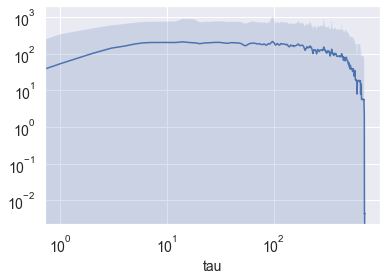

In [7]:
def compute_msd(trajectory, t_step, coords=['x', 'y']):

    tau = trajectory['t'].copy()
    shifts = np.floor(tau / t_step).astype(np.int)
    msds = np.zeros(shifts.size)
    msds_std = np.zeros(shifts.size)

    for i, shift in enumerate(shifts):
        diffs = trajectory[coords] - trajectory[coords].shift(-shift)
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()
        msds_std[i] = sqdist.std()

    msds = pd.DataFrame({'msds': msds, 'tau': tau, 'msds_std': msds_std})
    return msds

# load dataframe of trajectory
#df1.head()
#traj = df1
#dt = len(df1.index)
#df1.head()

# Parameters for random test trajectory
N = 5000
max_time = 100
dt =  1# len(df1.index)/len(df1.index) # max_time / N

t = np.linspace(0,  len(df1.index),  len(df1.index))
latitude1 = df1.latitude.values # y
longitude1 = df1.longitude.values #x


#xy = np.cumsum(np.random.choice([-1, 0, 1], size=(N, 2)), axis=0)
traj = pd.DataFrame({'t': t, 'x': longitude1, 'y': latitude1})
print(traj.head())



# Compute MSD
msd = compute_msd(traj, t_step=dt, coords=['x', 'y'])
print(msd.head())

# Plot MSD
ax = msd.plot(x="tau", y="msds", logx=True, logy=True, legend=False)
ax.fill_between(msd['tau'], msd['msds'] - msd['msds_std'], msd['msds'] + msd['msds_std'], alpha=0.2)

### Analysis of places around trajectories 

Openstreetmap analysis.

This can be used for a person who is traveling.


In [ ]:
import json # requests for APIs
import requests #load Python code that allow us to work with the JSON data format and the HTTP protocol

import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# https://www.digitalocean.com/community/tutorials/how-to-use-web-apis-in-python-3
# https://automating-gis-processes.github.io/CSC/notebooks/L3/retrieve_osm_data.html


# Specify the name that is used to seach for the data
place_name = "Hollywood, Los Angeles, USA"# Kremlin, Arbat "Kamppi, Helsinki, Finland"


# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
type(graph)

print('loading graph of USA')

# Plot the streets
fig, ax = ox.plot_graph(graph)


# Retrieve the footprint of our location
area = ox.gdf_from_place(place_name)
print('loading places')

# Retrieve buildings from the area
#buildings = ox.footprints(place_name) #buildings_from_place(place_name)

# What types are those? if there is any information about buildings_from_place
#print(type(area))
#print(type(buildings))

# Retrieve restaurants
restaurants = ox.pois_from_place(place_name, amenities=['restaurant'])

schools = ox.pois_from_place(place_name, amenities=['school'])


# How many schools do we have in this district?
len(schools)

# Available columns and names of amenity we are searching for
schools.columns

## Analysis of carbon footprint 

Analysis of carbon footprint for trajectories made by plane. We will use the following sources for this calculation.

The carbon footprint calculator 
https://www.carbonfootprint.com/calculator.aspx

We calculate carbon footprint from journeys in a separate file in the folder.



## Metadata around points of trajectories  
Now we want, given location point, to find some amenities around that point. 
For this we first need to convert coordinate to location name (city, country names).


Look at analysis in notebook *Mobility_and_amenities.ipynb*

## Additional data to analyze 

https://wiki.openstreetmap.org/wiki/Web_front_end 

https://www.localguidesconnect.com/t5/Announcements/How-Local-Guides-are-making-the-world-a-better-place/ba-p/1106735

http://www.cs.bham.ac.uk/research/projects/nsl/mobility-prediction/

Humanitarian openstreetmaps lists and contributors with metainformation https://www.hotosm.org/